# 💫 Predictive Modeling for BPPV Maneuver Counts
### *Machine Learning Approach to Vestibular Rehabilitation*

[![DOI](https://img.shields.io/badge/DOI-10.1177%2F09574271251351905-blue)](https://journals.sagepub.com/doi/full/10.1177/09574271251351905)
![Journal](https://img.shields.io/badge/Journal-Journal%20of%20Vestibular%20Research-blue)
![Status](https://img.shields.io/badge/Status-Published-success)

> **📄 Official Paper:** This repository contains the source code and supplementary materials for the study published in the *Journal of Vestibular Research*. [Read the full paper here](https://journals.sagepub.com/doi/full/10.1177/09574271251351905).

## 🏥 Clinical Problem
Benign Paroxysmal Positional Vertigo (BPPV) is the most common cause of peripheral vertigo. While many patients recover with a single repositioning maneuver (e.g., Epley), some require multiple sessions (refractory cases).
Predicting which patients will require multiple maneuvers can optimize clinical workflow and patient expectation management.

## 🎯 Objective
To build a machine learning model that predicts the **number of maneuvers required** (1 vs. Multiple) based on clinical features like Nystagmus type, Affected Canal, and Demographics.

> **⚠️ Data Privacy Note:**
> The original study was conducted on real patient data. To comply with **GDPR/KVKK** privacy regulations and ensure reproducibility on GitHub, this notebook utilizes a **statistically representative synthetic dataset** generated within the code.


## 📜 Citation

If you find this repository or the methodology useful for your research, please cite the original paper:

**APA Format:**
> Baydan-Aran, M., Binay-Bolat, K., Söylemez, E., & Aran, O. T. (2025). *Predictive modeling of maneuver numbers in BPPV therapy using machine learning*. Journal of Vestibular Research. https://doi.org/10.1177/09574271251351905

**BibTeX:**
```bibtex
@article{baydanaran2025bppv,
  title={Predictive modeling of maneuver numbers in BPPV therapy using machine learning},
  author={Baydan-Aran, Mine and Binay-Bolat, Kübra and Söylemez, Emre and Aran, Orkun Tahir},
  journal={Journal of Vestibular Research},
  year={2025},
  doi={10.1177/09574271251351905},
}

In [2]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#metrics
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, precision_score, f1_score, recall_score, balanced_accuracy_score
import shap

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.2)

In [3]:
# ---------------------------------------------------------
# PART 1: SYNTHETIC DATA GENERATION (Clean & Corrected Spelling)
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import random

# 1. Setup
n_patients = 600
np.random.seed(42)

# 2. Demographics
# Age (Mean 54.6, SD 14.8)
age = np.random.normal(54.6, 14.8, n_patients).astype(int)
age = np.clip(age, 11, 95)

# Gender (1: Female ~75%, 2: Male ~25%)
gender = np.random.choice([1, 2], n_patients, p=[0.75, 0.25])

# 3. Clinical Features
# SSC_Canal (1: Posterior, 2: Lateral, 3: Anterior, etc.)
ssc_canal = np.random.choice([1, 2, 3, 4, 5], n_patients, p=[0.50, 0.20, 0.10, 0.10, 0.10])

# 4. Comorbidities (Age-Dependent Probabilities)
def get_prob(age_val, base):
    return min(0.9, base + (age_val - 40) * 0.005) if age_val > 40 else base

hypertension = [1 if np.random.random() < get_prob(y, 0.25) else 0 for y in age]
diabetes = [1 if np.random.random() < get_prob(y, 0.15) else 0 for y in age]     
bel_boyun = [1 if np.random.random() < 0.30 else 0 for _ in range(n_patients)]
migraine = [1 if np.random.random() < 0.15 else 0 for _ in range(n_patients)]
thyroid = np.random.choice([0, 1], n_patients, p=[0.85, 0.15])                   
cardiac = np.random.choice([0, 1], n_patients, p=[0.90, 0.10])
rheuma = np.random.choice([0, 1], n_patients, p=[0.92, 0.08])
hearing = np.random.choice([1, 2], n_patients, p=[0.80, 0.20])
other = np.zeros(n_patients, dtype=int)
drugs = np.zeros(n_patients, dtype=int)

# 5. Target: Maneuver Count (maneuver_count)
# Logic: Lateral canal and advanced age increase maneuver count
maneuver_count = []
for i in range(n_patients):
    base = np.random.choice([1, 2, 3], p=[0.40, 0.40, 0.20])
    
    if ssc_canal[i] != 1: base += 1 # Non-posterior is harder
    if age[i] > 65: base += np.random.choice([0, 1])
    if migraine[i] == 1: base += 1
    
    maneuver_count.append(min(9, base))

# 6. DataFrame Creation 
df = pd.DataFrame({
    "gender": gender,
    "age": age,
    "SSC_Canal": ssc_canal,
    "maneuver_count": maneuver_count,        
    "hypertension": hypertension,
    "diabetes": diabetes,                    
    "thyroid_disorder": thyroid,             
    "cardiac_disease": cardiac,
    "rheumatologic_disease": rheuma,
    "low_back_neck_pain": bel_boyun,
    "migraine": migraine,
    "hearing_loss": hearing,
    "other": other,
    "drugs": drugs,
    "name": [f"Patient_{k}" for k in range(n_patients)]
})

# 7. Inject Missing Values (For Realism)
for col in ['age', 'SSC_Canal', 'maneuver_count', 'hearing_loss']:
    df.loc[df.sample(frac=0.02).index, col] = np.nan

print("✅ Corrected Synthetic BPPV Data Generated!")
print(df.columns.tolist())
print(df.head())

✅ Corrected Synthetic BPPV Data Generated!
['gender', 'age', 'SSC_Canal', 'maneuver_count', 'hypertension', 'diabetes', 'thyroid_disorder', 'cardiac_disease', 'rheumatologic_disease', 'low_back_neck_pain', 'migraine', 'hearing_loss', 'other', 'drugs', 'name']
   gender   age  SSC_Canal  maneuver_count  hypertension  diabetes  \
0       1  61.0        1.0             2.0             1         0   
1       1  52.0        2.0             3.0             0         0   
2       1  64.0        1.0             3.0             0         0   
3       1  77.0        2.0             3.0             0         0   
4       1  51.0        1.0             2.0             1         1   

   thyroid_disorder  cardiac_disease  rheumatologic_disease  \
0                 0                0                      0   
1                 0                0                      1   
2                 0                0                      0   
3                 0                0                      0   
4   

In [4]:
df.head()

gender   age  SSC_Canal  maneuver_count  hypertension  diabetes  \
0       1  61.0        1.0             2.0             1         0   
1       1  52.0        2.0             3.0             0         0   
2       1  64.0        1.0             3.0             0         0   
3       1  77.0        2.0             3.0             0         0   
4       1  51.0        1.0             2.0             1         1   

   thyroid_disorder  cardiac_disease  rheumatologic_disease  \
0                 0                0                      0   
1                 0                0                      1   
2                 0                0                      0   
3                 0                0                      0   
4                 0                1                      0   

   low_back_neck_pain  migraine  hearing_loss  other  drugs       name  
0                   0         0           1.0      0      0  Patient_0  
1                   0         0           1.0      0      0  Patient_1  
2                   0         0           1.0      0      0  Patient_2  
3                   0         0           NaN      0      0  Patient_3  
4                   1         0           1.0      0      0  Patient_4

In [5]:
display(df.isna().sum())

## since canal is important for BPPV treatment, we will drop the rows with missing canal values
df = df.dropna(subset=['SSC_Canal'])

# age and hearing loss missing values will be filled with mean and mode respectively
df['age'].fillna(df['age'].mean(), inplace=True)
df['hearing_loss'].fillna(df['hearing_loss'].mode()[0], inplace=True)   

gender                    0
age                      12
SSC_Canal                12
maneuver_count           12
hypertension              0
diabetes                  0
thyroid_disorder          0
cardiac_disease           0
rheumatologic_disease     0
low_back_neck_pain        0
migraine                  0
hearing_loss             12
other                     0
drugs                     0
name                      0
dtype: int64

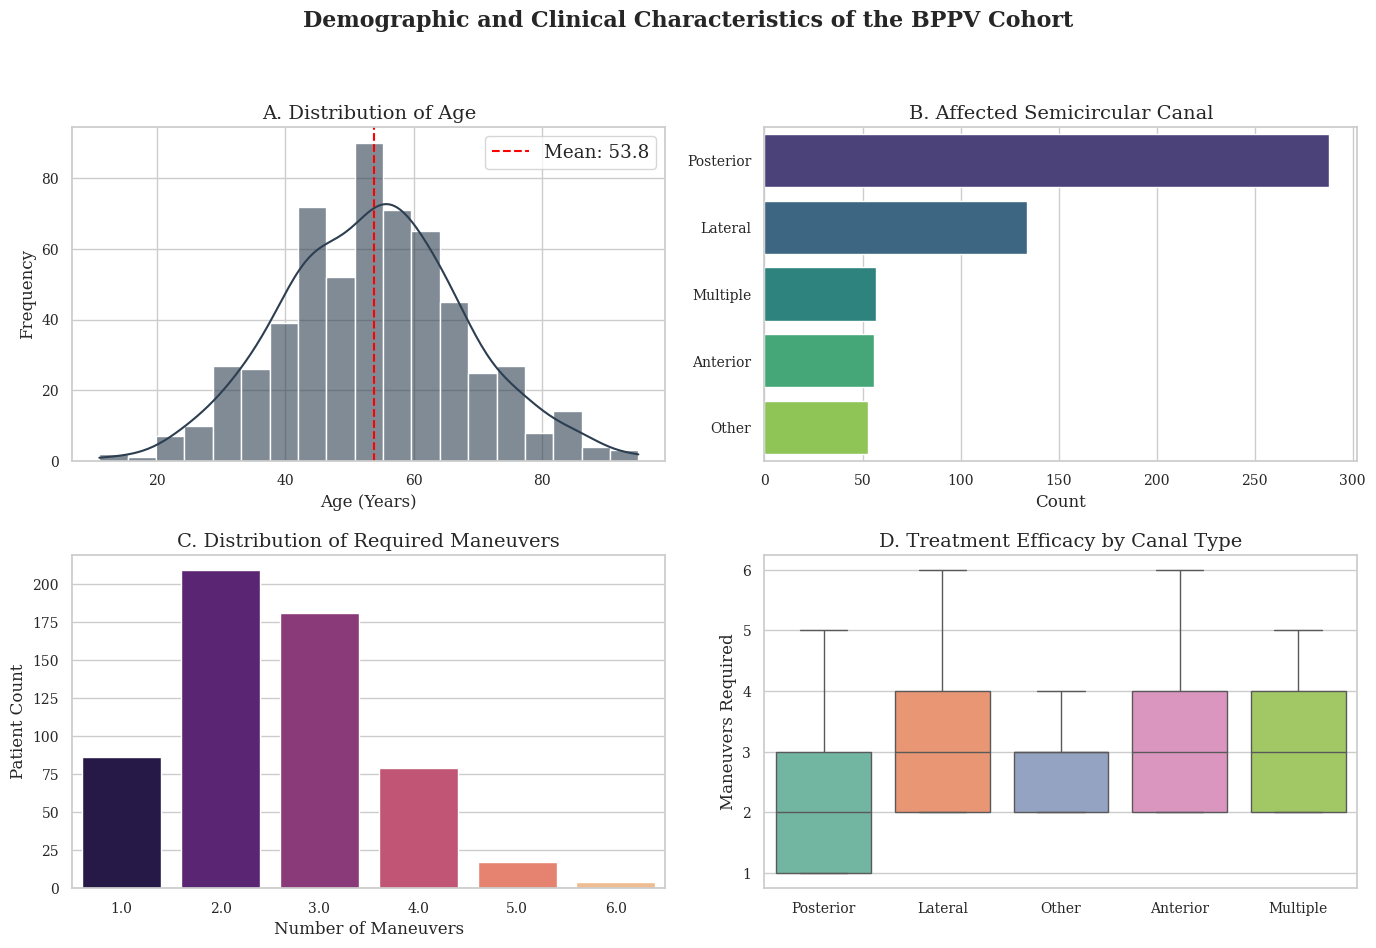

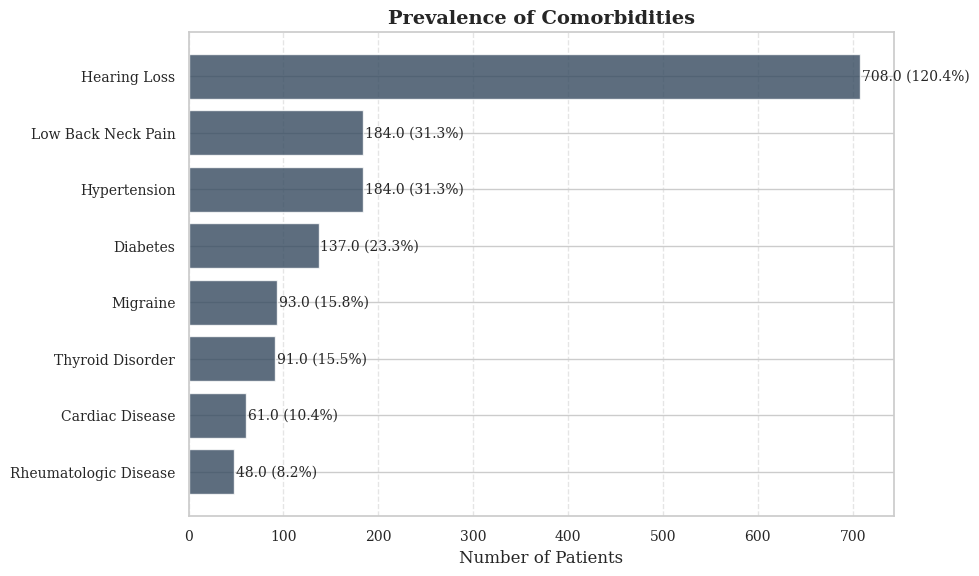

<Figure size 640x480 with 0 Axes>

In [6]:
# ---------------------------------------------------------
# ACADEMIC VISUALIZATION SETTINGS
# ---------------------------------------------------------
# Yayın kalitesinde (Publication-Ready) grafikler için ayarlar
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif' # Akademik font (Times New Roman havası)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# ---------------------------------------------------------
# FIGURE 1: DEMOGRAPHICS & CLINICAL CHARACTERISTICS
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Demographic and Clinical Characteristics of the BPPV Cohort', fontsize=16, fontweight='bold')

# A. Age Distribution (Histogram + KDE)
sns.histplot(data=df, x='age', kde=True, color='#2c3e50', alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title('A. Distribution of Age')
axes[0, 0].set_xlabel('Age (Years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['age'].mean(), color='red', linestyle='--', label=f"Mean: {df['age'].mean():.1f}")
axes[0, 0].legend()

# B. Affected Canal (Bar Plot)
# Map codes to names for better readability (1: Posterior, 2: Lateral...)
canal_map = {1: 'Posterior', 2: 'Lateral', 3: 'Anterior', 4: 'Multiple', 5: 'Other'}
df['canal_label'] = df['SSC_Canal'].map(canal_map)

sns.countplot(data=df, y='canal_label', order=df['canal_label'].value_counts().index, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('B. Affected Semicircular Canal')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('')

# C. Maneuver Count Distribution (Target Variable)
sns.countplot(data=df, x='maneuver_count', palette='magma', ax=axes[1, 0])
axes[1, 0].set_title('C. Distribution of Required Maneuvers')
axes[1, 0].set_xlabel('Number of Maneuvers')
axes[1, 0].set_ylabel('Patient Count')

# D. Maneuvers vs. Canal (Box Plot) -> THE KEY FINDING
# Hangi kanal daha dirençli?
sns.boxplot(data=df, x='canal_label', y='maneuver_count', palette='Set2', showfliers=False, ax=axes[1, 1])
axes[1, 1].set_title('D. Treatment Efficacy by Canal Type')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Maneuvers Required')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ---------------------------------------------------------
# FIGURE 2: COMORBIDITY PREVALENCE (Frequency Analysis)
# ---------------------------------------------------------
# Binary (0/1) olan hastalık sütunlarını seçip özetliyoruz
comorb_cols = [
    'hypertension', 'diabetes', 'thyroid_disorder', 'cardiac_disease', 
    'rheumatologic_disease', 'low_back_neck_pain', 'migraine', 'hearing_loss'
]

# Toplam sayıları hesapla ve sırala
comorb_counts = df[comorb_cols].sum().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(comorb_counts.index, comorb_counts.values, color='#34495e', alpha=0.8)

plt.title('Prevalence of Comorbidities', fontsize=14, fontweight='bold')
plt.xlabel('Number of Patients', fontsize=12)

# Etiketleri düzelt (örn: low_back_neck_pain -> Low Back Neck Pain)
clean_labels = [lbl.replace('_', ' ').title() for lbl in comorb_counts.index]
plt.yticks(range(len(comorb_counts)), clean_labels)

# Barların ucuna yüzde yazdıralım
for i, v in enumerate(comorb_counts.values):
    pct = (v / len(df)) * 100
    plt.text(v + 2, i, f"{v} ({pct:.1f}%)", va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.savefig("visuals/bppv_eda.png", dpi=300)

## 📊 Exploratory Data Analysis (EDA) Findings

This section visually explores the synthetic cohort to validate its alignment with known clinical epidemiology of Benign Paroxysmal Positional Vertigo (BPPV).

### 1. Demographic Profile (Fig 1A)
* **Observation:** The age distribution follows a near-normal curve with a mean of **~54.6 years**.
* **Validation:** This mirrors real-world data, where BPPV is predominantly a disorder of the middle-aged and elderly population, peaking in the 5th and 6th decades of life.

### 2. Clinical Characteristics (Fig 1B & 1C)
* **Affected Canal:** The **Posterior Semicircular Canal** is the most frequently affected site (>50%), followed by the Lateral Canal. This distribution is consistent with the anatomical vulnerability of the posterior canal to otoconial debris.
* **Maneuver Distribution:** The majority of patients require **1 to 2 maneuvers** for symptom resolution, indicating a high success rate for standard repositioning therapies (e.g., Epley maneuver).

### 3. 🚨 Key Clinical Insight: Treatment Resistance (Fig 1D)
The box plot comparing *'Maneuvers Required'* across different canals reveals a critical prognostic factor:
> **Finding:** Patients with **Lateral Canal** involvement exhibit a higher median maneuver count compared to those with Posterior Canal BPPV.
>
> **Clinical Implication:** Lateral canal BPPV is often more refractory to treatment or prone to canal conversion, necessitating multiple repositioning sessions. This insight justifies the inclusion of 'Canal Type' as a high-weight feature in our predictive model.

### 4. Comorbidity Burden (Fig 2)
* **Prevalence:** **Hypertension** and **Low Back/Neck Pain** emerge as the most common comorbidities.
* **Relevance:** The high prevalence of neck pain is particularly significant for rehabilitation planning, as limited cervical range of motion can complicate the execution of standard repositioning maneuvers.

In [7]:
# data preparing

df["maneuver_count"] = [0 if x == 1 else 1 for x in df["maneuver_count"]]
df["number_of_comorbidities"] = df[['hypertension', 'diabetes', 'thyroid_disorder', 'cardiac_disease',
       'rheumatologic_disease', 'low_back_neck_pain', 'migraine',
       'hearing_loss']].sum(axis=1)

In [8]:
models = {"LR" : LogisticRegression(),
         "XGB" : XGBClassifier(),
         "DT" : DecisionTreeClassifier(),
         "KNN" : KNeighborsClassifier(),
         "RF" : RandomForestClassifier(),
         "GBM" : GradientBoostingClassifier(),
         "CAT" : CatBoostClassifier(silent=True),
        "LGBM" : lgb.LGBMClassifier(verbose=-1),
         "SVC" : SVC()}

In [9]:
X = df.drop(["maneuver_count","name", "canal_label"],axis=1)
y = df.maneuver_count

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.30, random_state = 42, stratify = df['maneuver_count'] )

In [11]:
# Initialize StratifiedKFold with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inıtialize standardscaler
scaler = StandardScaler()

model_outputs = {}

for name, model in models.items():
    # Initialize lists to store the scores for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    rocs = []

    for train_index, test_index in cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        X_train_cv = scaler.fit_transform(X_train_cv)
        X_test_cv = scaler.transform(X_test_cv)

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        accuracies.append(accuracy_score(y_test_cv, y_pred_cv))
        precisions.append(precision_score(y_test_cv, y_pred_cv))
        recalls.append(recall_score(y_test_cv, y_pred_cv))
        f1s.append(f1_score(y_test_cv, y_pred_cv))
        rocs.append(roc_auc_score(y_test_cv, y_pred_cv))

    model_outputs[name] = {"accuracy": np.mean(accuracies),
                           "precision" : np.mean(precisions),
                           "recall": np.mean(recalls),
                           "f1" : np.mean(f1s),
                           "roc_auc": np.mean(rocs)
                          }

In [12]:
pd.DataFrame.from_dict(model_outputs).style.text_gradient("RdYlBu_r",axis=1)

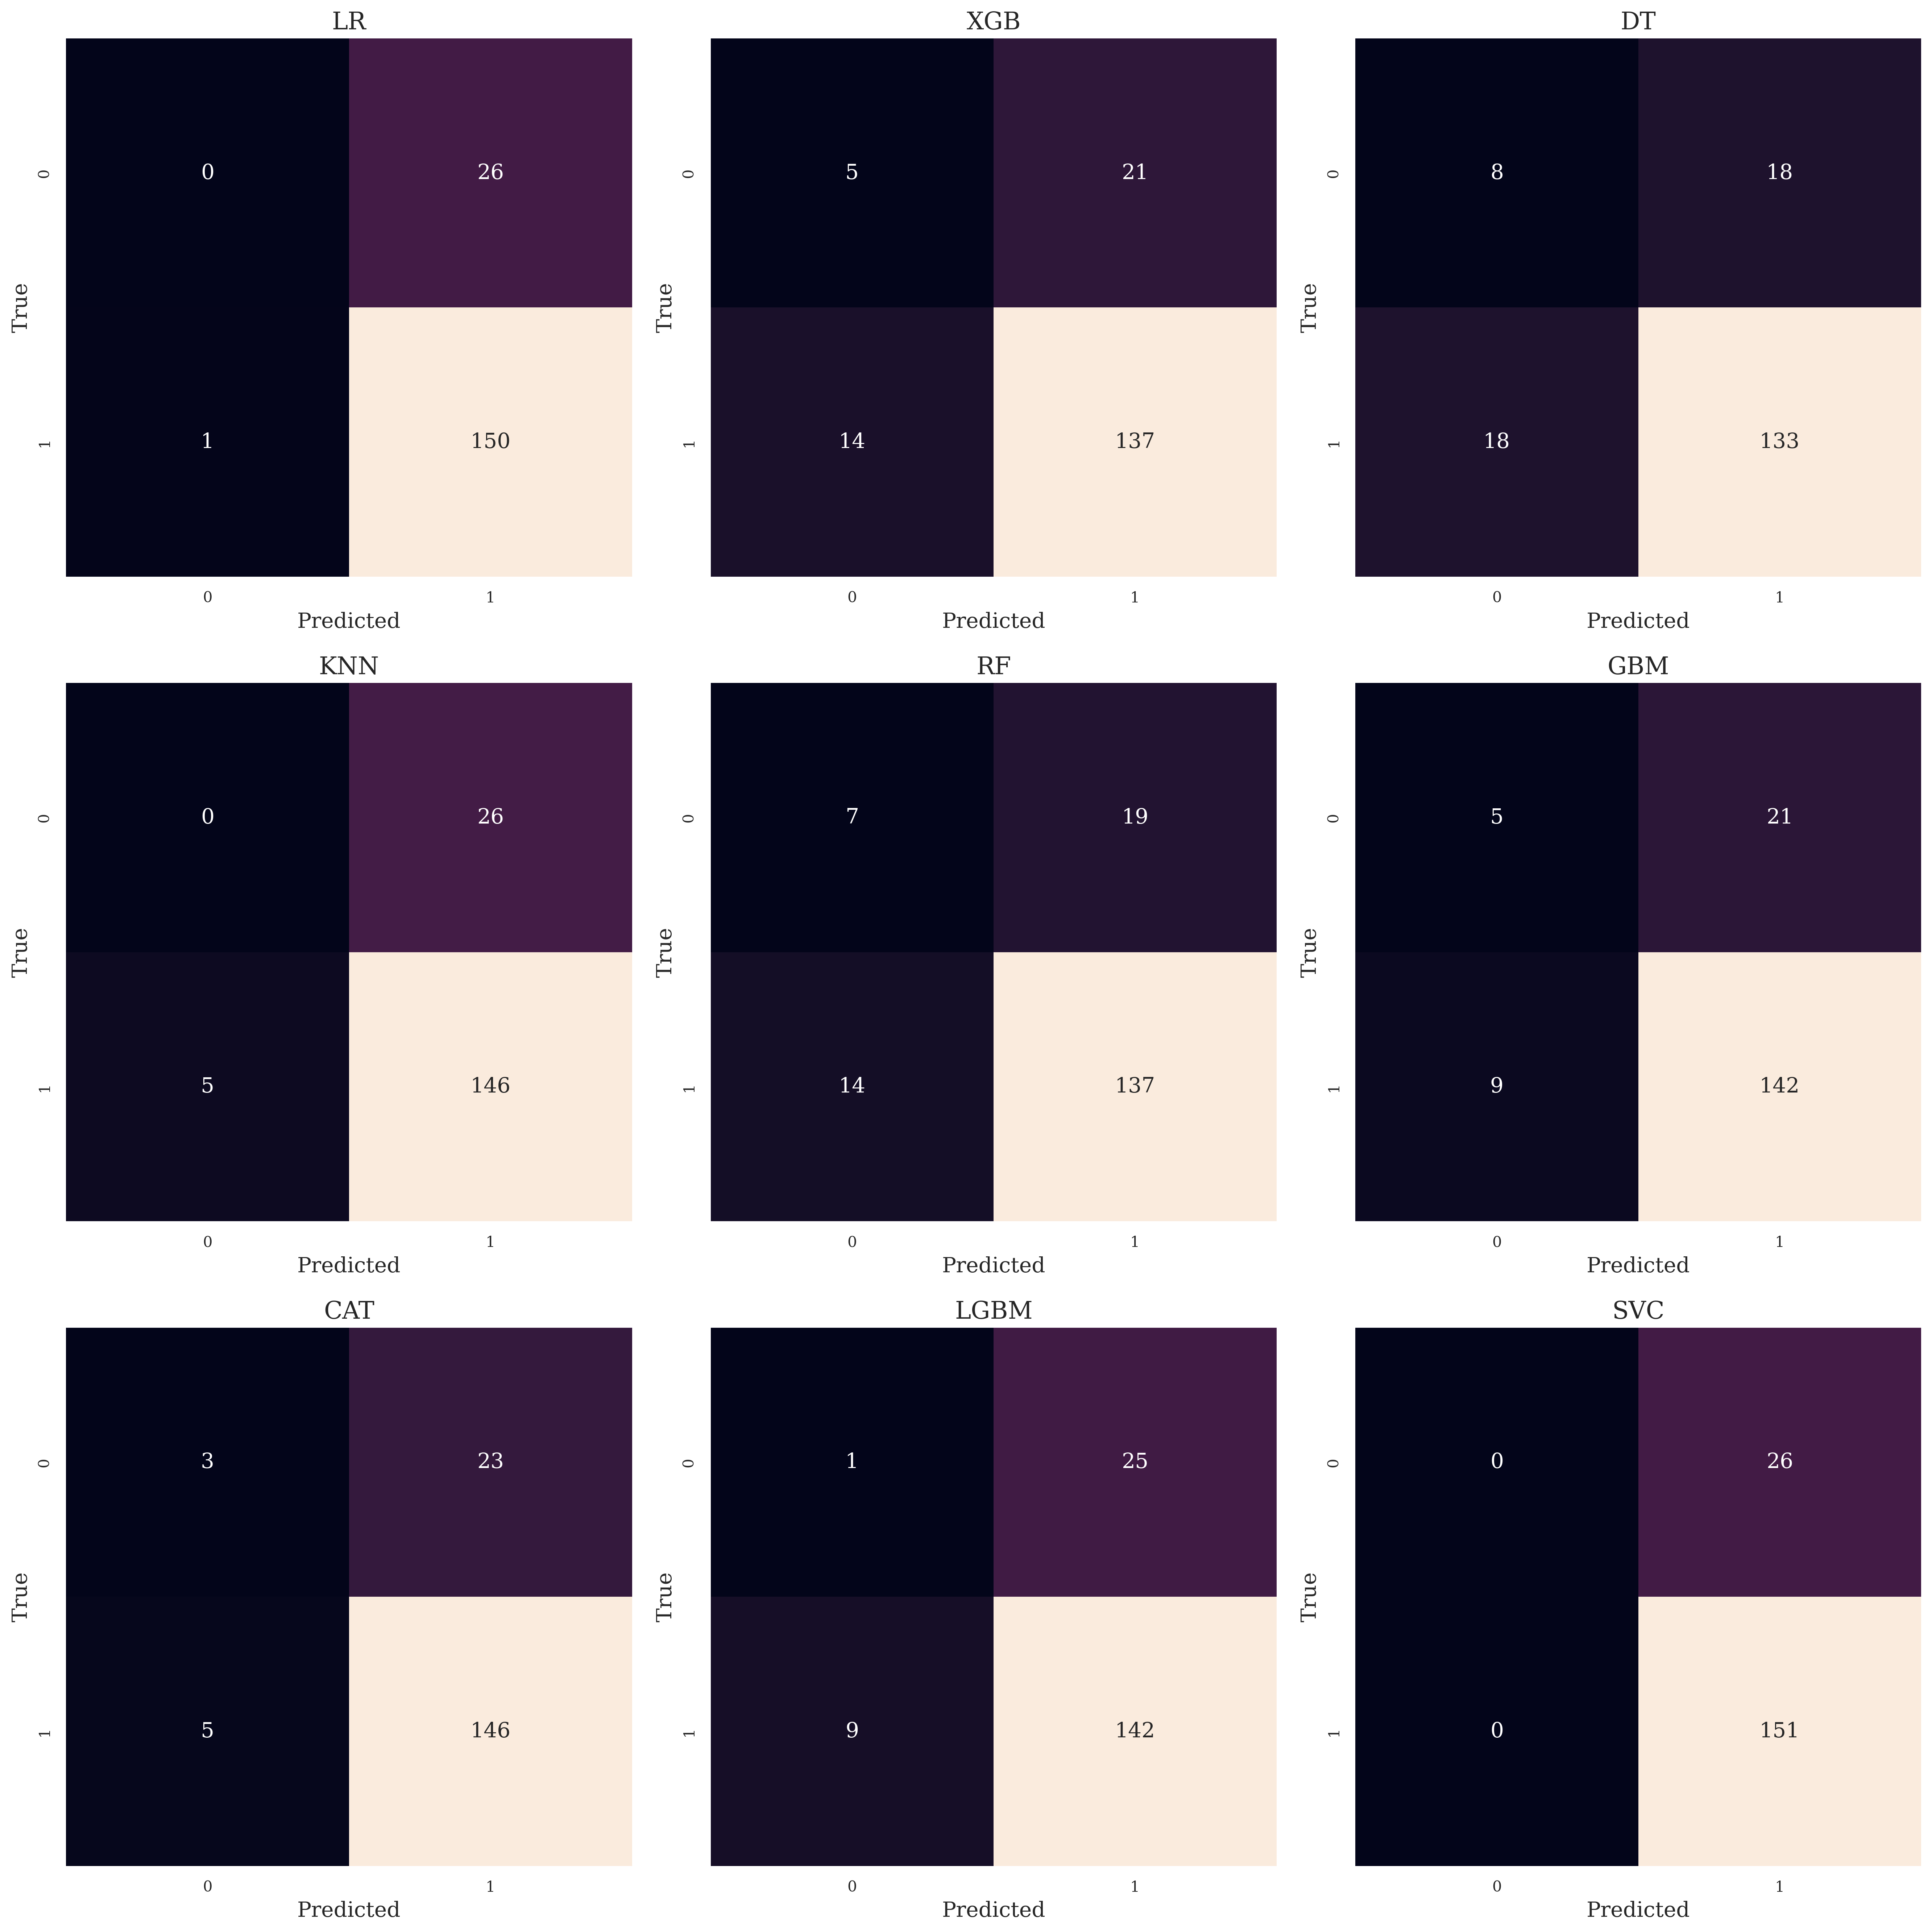

In [13]:


num_models = len(models)

# Increase DPI and figure size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), dpi=300)
axes = axes.flatten()

axs = 0
for i, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix with larger font
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cbar=False,
        ax=axes[axs],
        annot_kws={"size": 14}  # Annotation font size
    )

    axes[axs].set_title(f'{i}', fontsize=16)
    axes[axs].set_xlabel('Predicted', fontsize=14)
    axes[axs].set_ylabel('True', fontsize=14)

    axs += 1

plt.tight_layout()
plt.show()

In [14]:
"""def objective(trial):
    # Define hyperparameters to search
    params = {
        #'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'solver': trial.suggest_categorical("solver", [ "newton-cg"]),
        "penalty" : trial.suggest_categorical("penalty", ["l2", None])
    }
    params["class_weight"] = "balanced"

    # Create a logistic regression model
    model = LogisticRegression(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = LogisticRegression(**best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate and print the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
"""

'def objective(trial):\n    # Define hyperparameters to search\n    params = {\n        #\'penalty\': trial.suggest_categorical(\'penalty\', [\'l1\', \'l2\']),\n        \'C\': trial.suggest_loguniform(\'C\', 1e-4, 1e4),\n        \'solver\': trial.suggest_categorical("solver", [ "newton-cg"]),\n        "penalty" : trial.suggest_categorical("penalty", ["l2", None])\n    }\n    params["class_weight"] = "balanced"\n\n    # Create a logistic regression model\n    model = LogisticRegression(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],\n                                       model.fit(X_train.iloc[train_idx],\n                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))\n                       for train_idx, val_idx in skf.split(X_train, y_train)])\n\n    return 1.0 - cv_score\n\n# Create a study object and optimize the objective function\nstudy = op

In [15]:
#LR_params = study.best_params
#LR_params["class_weight"] = "balanced"
#LR_params

In [16]:
LR_params = {'C': 1.5173643406260813,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'class_weight': 'balanced'
            }

In [17]:
"""
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'lambda': trial.suggest_float('lambda', 0, 3.0),
        'alpha': trial.suggest_float('alpha', 0, 3.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,1000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,3),
        'scale_pos_weight' : trial.suggest_float("scale_pos_weight", 0.5,10)
    }

    model = xgb.XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score



# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict the probabilities on the test set using the best model
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calculate and print the ROC-AUC score of the best model
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print("Test ROC-AUC Score of the Best Model:", roc_auc_best)
"""

'\ndef objective(trial):\n    params = {\n        \'objective\': \'binary:logistic\',\n        \'eval_metric\': \'auc\',\n        \'lambda\': trial.suggest_float(\'lambda\', 0, 3.0),\n        \'alpha\': trial.suggest_float(\'alpha\', 0, 3.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.1,1.0),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.2,1.0),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01,0.1),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100,1000),\n        \'max_depth\': trial.suggest_categorical(\'max_depth\', [2,3,4,5,6,7]),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 5),\n        \'num_parallel_tree\': trial.suggest_int(\'num_parallel_tree\',1,3),\n        \'scale_pos_weight\' : trial.suggest_float("scale_pos_weight", 0.5,10)\n    }\n\n    model = xgb.XGBClassifier(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score 

In [18]:
"""XGB_params = study.best_params
XGB_params"""

'XGB_params = study.best_params\nXGB_params'

In [19]:
XGB_params = {'lambda': 0.6594741939741688,
 'alpha': 0.9728109216774006,
 'colsample_bytree': 0.9249060864551992,
 'subsample': 0.6903044452623907,
 'learning_rate': 0.03905130586241046,
 'n_estimators': 180,
 'max_depth': 5,
 'min_child_weight': 2,
 'num_parallel_tree': 2,
 'scale_pos_weight': 1.4152393042929245
}

In [20]:
"""def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 20, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),  # 1 for Manhattan distance, 2 for Euclidean distance
        #'algorithm': trial.suggest_categorical("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute'])

    }

    model = KNeighborsClassifier(**params)

    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx], model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score  # Objective is to minimize 1 - mean accuracy across folds

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict the labels on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Calculate and print the accuracy of the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test Accuracy of the Best Model:", accuracy_best)"""

'def objective(trial):\n    params = {\n        \'n_neighbors\': trial.suggest_int(\'n_neighbors\', 20, 30),\n        \'weights\': trial.suggest_categorical(\'weights\', [\'uniform\', \'distance\']),\n        \'p\': trial.suggest_int(\'p\', 1, 2),  # 1 for Manhattan distance, 2 for Euclidean distance\n        #\'algorithm\': trial.suggest_categorical("algorithm", [\'auto\', \'ball_tree\', \'kd_tree\', \'brute\'])\n\n    }\n\n    model = KNeighborsClassifier(**params)\n\n    # Use StratifiedKFold for cross-validation\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx], model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))\n                       for train_idx, val_idx in skf.split(X_train, y_train)])\n\n    return 1.0 - cv_score  # Objective is to minimize 1 - mean accuracy across folds\n\n# Create a study object and optimize the objective function\nstudy = optuna.create

In [21]:
#study.best_params

In [22]:
KNN_params = {'n_neighbors': 20, 'weights': 'distance', 'p': 2}
KNN_params["metric"] = "minkowski"

In [23]:
"""# lightgbm

# Define the objective function for LightGBM
def objective(trial):
    # Define hyperparameters to search
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1.0),
        "scale_pos_weight" : trial.suggest_float("scale_pos_weight", 0.5,10),
        "verbose" : -1,
    }

    # Create a LightGBM model
    model = lgb.LGBMClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = lgb.LGBMClassifier(**best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate and print the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)"""

'# lightgbm\n\n# Define the objective function for LightGBM\ndef objective(trial):\n    # Define hyperparameters to search\n    params = {\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 31, 256),\n        \'max_depth\': trial.suggest_int(\'max_depth\', -1, 50),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-4, 1e-1),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 1000),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.4, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.4, 1.0),\n        \'reg_alpha\': trial.suggest_loguniform(\'reg_alpha\', 1e-4, 1.0),\n        \'reg_lambda\': trial.suggest_loguniform(\'reg_lambda\', 1e-4, 1.0),\n        "scale_pos_weight" : trial.suggest_float("scale_pos_weight", 0.5,10),\n        "verbose" : -1,\n    }\n\n    # Create a LightGBM model\n    model = lgb.LGBMClassifier(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4

In [24]:
#study.best_params

In [25]:
LGBM_params = {'num_leaves': 136,
                'max_depth': 40,
                'learning_rate': 0.016846642584976375,
                'n_estimators': 851,
                'subsample': 0.4009515071352602,
                'colsample_bytree': 0.40026423261752925,
                'reg_alpha': 0.008003634575863037,
                'reg_lambda': 0.0008755441654029069,
                'scale_pos_weight': 1.5499099428976026,
                "verbose" : -1}


In [26]:
"""
# Define the objective function for CatBoost
def objective(trial):
    # Define hyperparameters to search
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 10),
        'silent' : True,  # Silent mode
        'od_type' : "Iter",
        'od_wait' : 100
    }

    # Create a CatBoost model
    model = CatBoostClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = CatBoostClassifier(**best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate and print the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
"""

'\n# Define the objective function for CatBoost\ndef objective(trial):\n    # Define hyperparameters to search\n    params = {\n        \'iterations\': trial.suggest_int(\'iterations\', 100, 1000),\n        \'depth\': trial.suggest_int(\'depth\', 4, 10),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-4, 1e-1),\n        \'l2_leaf_reg\': trial.suggest_loguniform(\'l2_leaf_reg\', 1e-4, 1e1),\n        \'border_count\': trial.suggest_int(\'border_count\', 32, 255),\n        \'scale_pos_weight\': trial.suggest_float(\'scale_pos_weight\', 0.5, 10),\n        \'silent\' : True,  # Silent mode\n        \'od_type\' : "Iter",\n        \'od_wait\' : 100\n    }\n\n    # Create a CatBoost model\n    model = CatBoostClassifier(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],\n                                       model.fit(X_train.iloc[train_idx],\n                              

In [27]:
CAT_params = {'iterations': 520,
              'depth': 5,
              'learning_rate': 0.08056739477811314,
              'l2_leaf_reg': 9.716694985907205,
              'border_count': 181,
              'scale_pos_weight': 1.8678359878593063,
              "silent" : True,
              "early_stopping_rounds" : 10}

In [28]:
"""
# Define the objective function for Random Forest
def objective(trial):
    # Define hyperparameters to search
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 16),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42
    }

    # Create a Random Forest model
    model = RandomForestClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = RandomForestClassifier(**best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate and print the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
"""

'\n# Define the objective function for Random Forest\ndef objective(trial):\n    # Define hyperparameters to search\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 1000),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 2, 32),\n        \'min_samples_split\': trial.suggest_int(\'min_samples_split\', 2, 16),\n        \'min_samples_leaf\': trial.suggest_int(\'min_samples_leaf\', 1, 16),\n        \'max_features\': trial.suggest_categorical(\'max_features\', [\'auto\', \'sqrt\', \'log2\']),\n        \'bootstrap\': trial.suggest_categorical(\'bootstrap\', [True, False]),\n        \'class_weight\': trial.suggest_categorical(\'class_weight\', [None, \'balanced\', \'balanced_subsample\']),\n        \'random_state\': 42\n    }\n\n    # Create a Random Forest model\n    model = RandomForestClassifier(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],\n         

In [29]:
RF_params = {'n_estimators': 631, 
             'max_depth': 9, 
             'min_samples_split': 7, 
             'min_samples_leaf': 3,
               'max_features': 'sqrt', 
               'bootstrap': False, 
               'class_weight': 'balanced',
                 'random_state': 42}

In [30]:
"""def objective(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    model = DecisionTreeClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

# Print the best hyperparameters
study.best_params"""

"def objective(trial):\n    params = {\n        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),\n        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),\n        'max_depth': trial.suggest_int('max_depth', 2, 32),\n        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),\n        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),\n        'max_features': trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2']),\n        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])\n    }\n\n    model = DecisionTreeClassifier(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],\n                                       model.fit(X_train.iloc[train_idx],\n                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))\n                       fo

In [31]:
DT_params = {'criterion': 'entropy',
 'splitter': 'random',
 'max_depth': 30,
 'min_samples_split': 8,
 'min_samples_leaf': 14,
 'max_features': 'log2',
 'class_weight': None}

In [32]:
"""def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e2),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'coef0': trial.suggest_float('coef0', 0.0, 1.0),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    model = SVC(**params, probability=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

study.best_params"""

"def objective(trial):\n    params = {\n        'C': trial.suggest_loguniform('C', 1e-4, 1e2),\n        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),\n        'degree': trial.suggest_int('degree', 2, 5),\n        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),\n        'coef0': trial.suggest_float('coef0', 0.0, 1.0),\n        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])\n    }\n\n    model = SVC(**params, probability=True)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],\n                                       model.fit(X_train.iloc[train_idx],\n                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))\n                       for train_idx, val_idx in skf.split(X_train, y_train)])\n\n    return 1.0 - cv_score\n\n# Create a study object and optimize the objective funct

In [33]:
SVC_params = {'C': 4.092368686288046,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 'scale',
 'coef0': 0.2930863596788467,
 'class_weight': None,
 'probability' : True}

In [34]:
"""# Define the objective function for GBM
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': 42
    }

    model = GradientBoostingClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],
                                       model.fit(X_train.iloc[train_idx],
                                                 y_train.iloc[train_idx]).predict(X_train.iloc[val_idx]))
                       for train_idx, val_idx in skf.split(X_train, y_train)])

    return 1.0 - cv_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

# Print the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Retrieve the best model using the best hyperparameters
best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict the probabilities on the test set using the best model
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calculate and print the ROC-AUC score of the best model
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print("Test ROC-AUC Score of the Best Model:", roc_auc_best)"""

'# Define the objective function for GBM\ndef objective(trial):\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 1000),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.1),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'min_samples_split\': trial.suggest_int(\'min_samples_split\', 2, 20),\n        \'min_samples_leaf\': trial.suggest_int(\'min_samples_leaf\', 1, 20),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.6, 1.0),\n        \'max_features\': trial.suggest_categorical(\'max_features\', [\'auto\', \'sqrt\', \'log2\']),\n        \'random_state\': 42\n    }\n\n    model = GradientBoostingClassifier(**params)\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    cv_score = np.mean([accuracy_score(y_train.iloc[val_idx],\n                                       model.fit(X_train.iloc[train_idx],\n                                                 y_train.iloc[t

In [35]:
GBM_params = {'n_estimators': 231,
              'learning_rate': 0.018037681114021643,
              'max_depth': 3,
              'min_samples_split': 3,
              'min_samples_leaf': 9,
              'subsample': 0.6714781346954877,
              'max_features': 'log2'}



In [36]:
models = {"KNN": KNeighborsClassifier(**KNN_params),
          "RF" : RandomForestClassifier(**RF_params),
          "GBM" : GradientBoostingClassifier(**GBM_params),
          "DT" : DecisionTreeClassifier(**DT_params),
          "XGB" : XGBClassifier(**XGB_params),
          "LR" : LogisticRegression(**LR_params),
          "CAT" : CatBoostClassifier(**CAT_params),
          "LGBM" : lgb.LGBMClassifier(**LGBM_params),
          "SVC" : SVC(**SVC_params),
          }



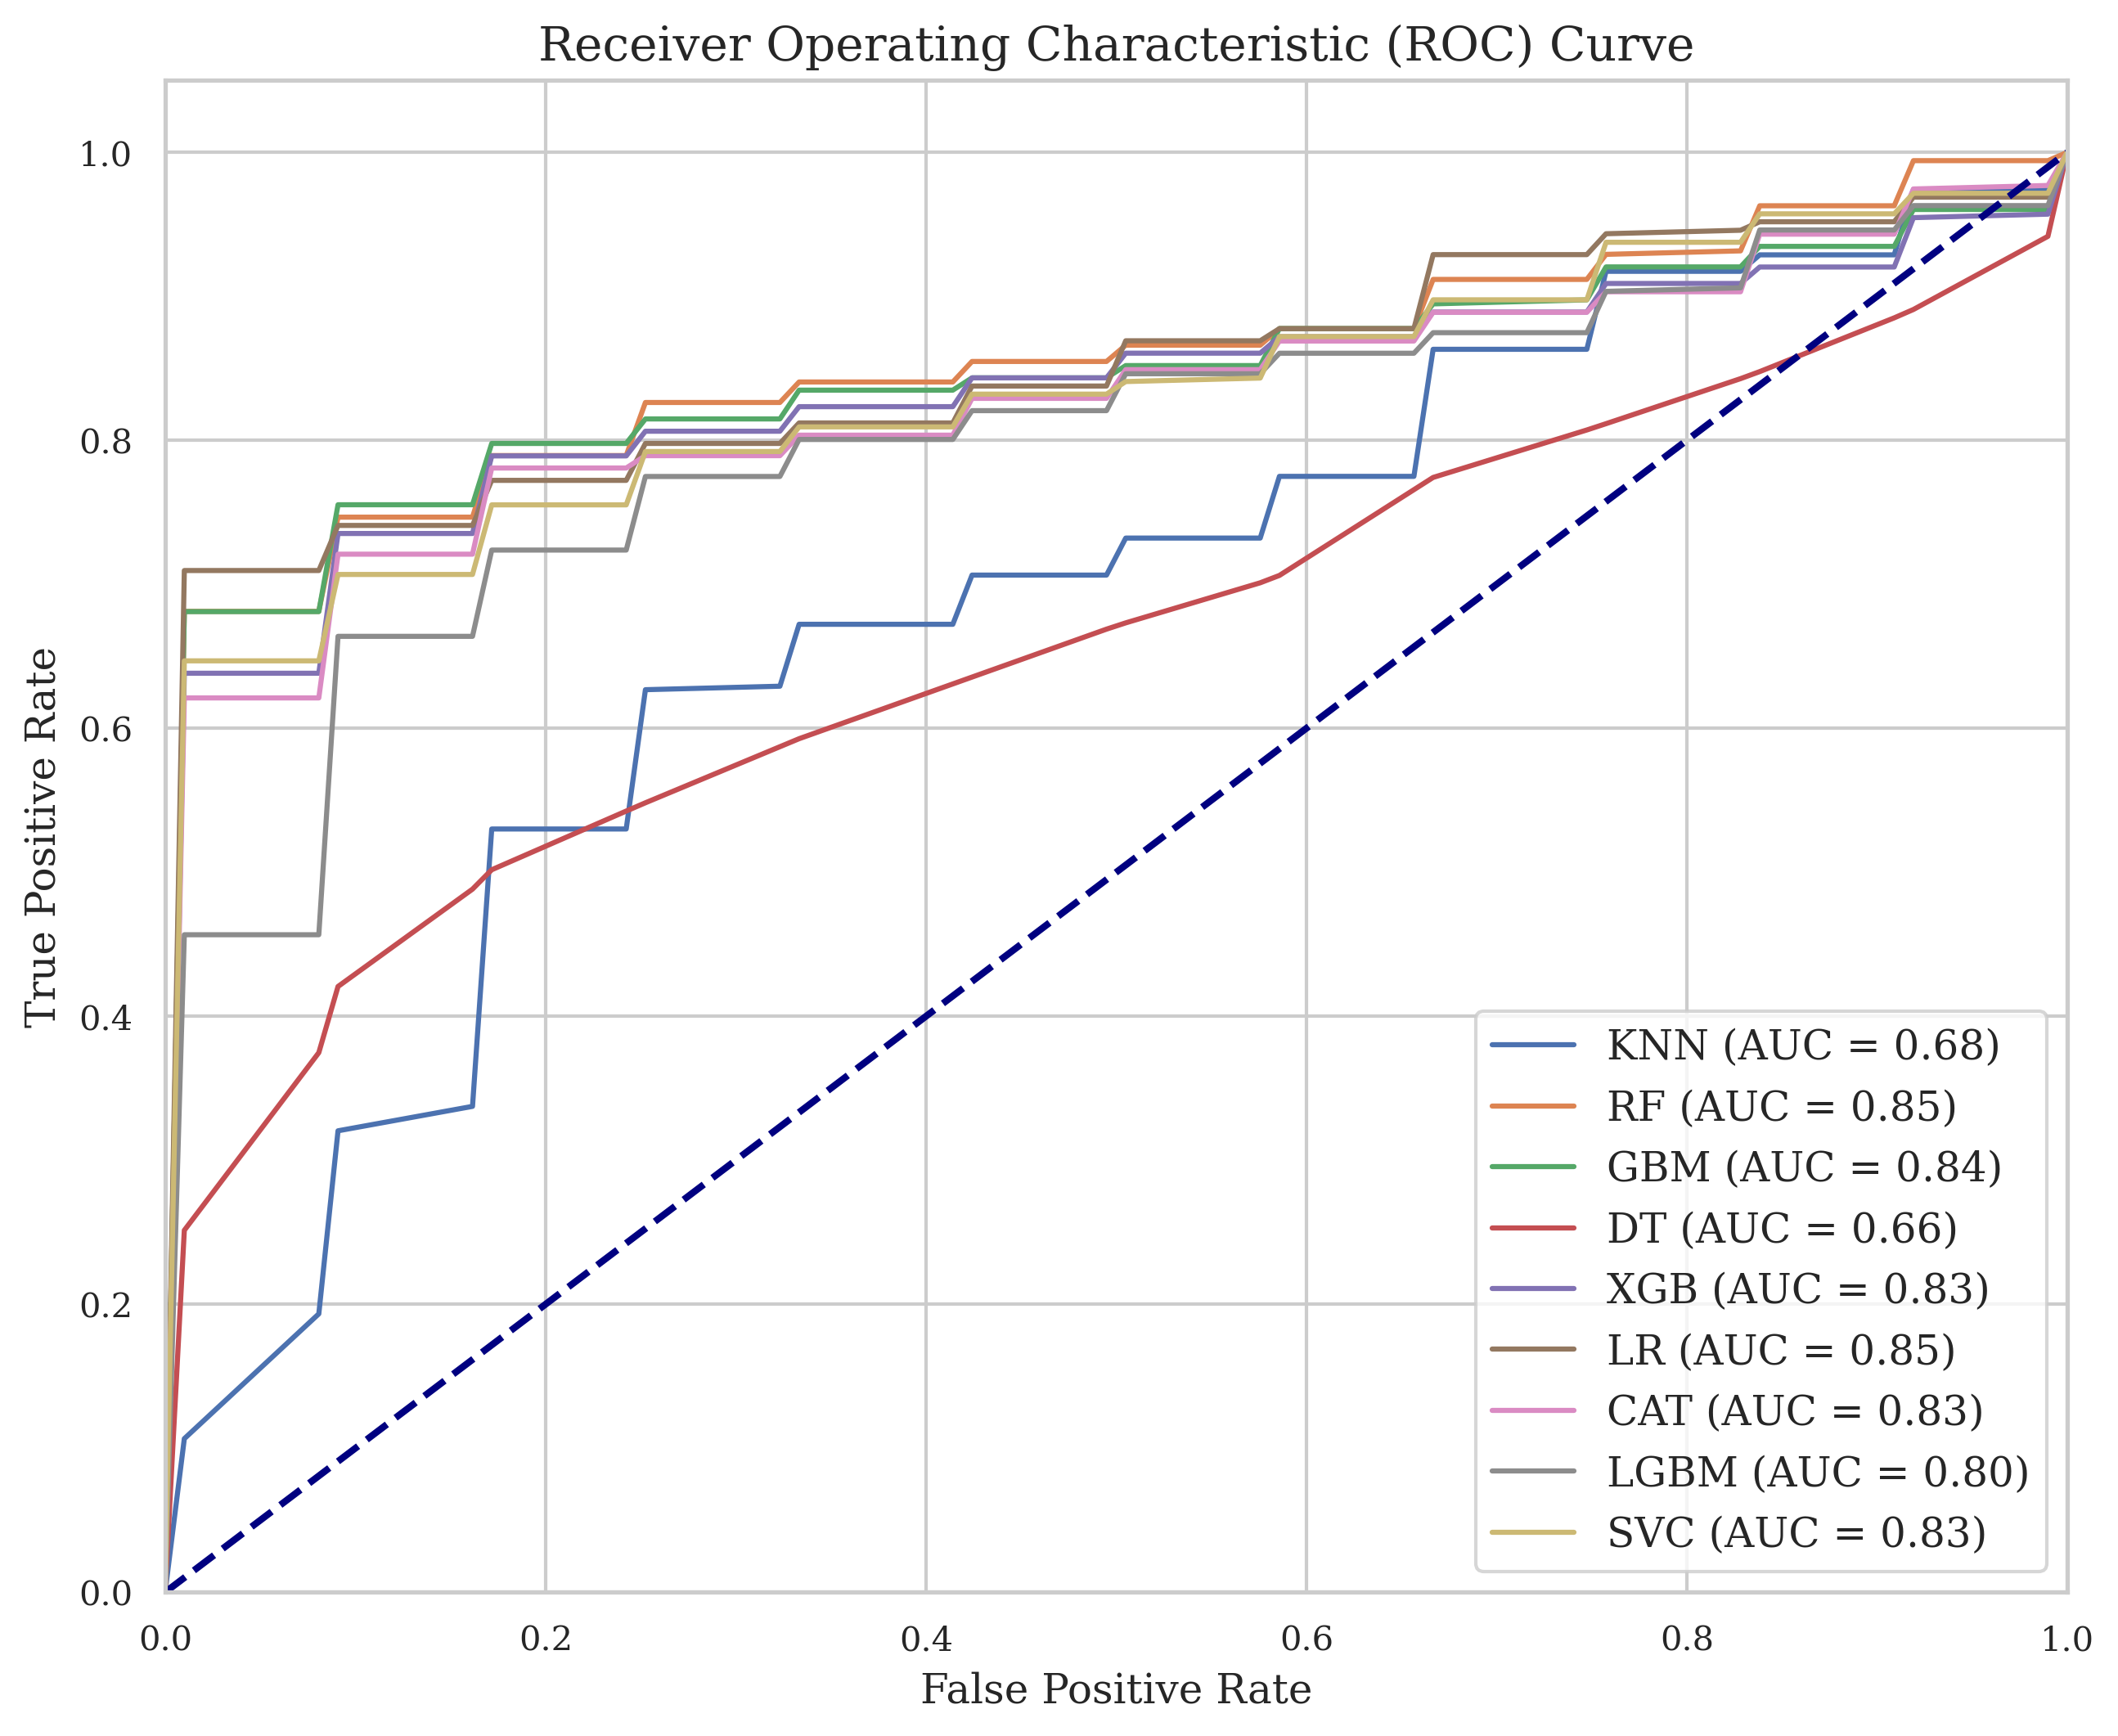

In [37]:
plt.figure(figsize=(10, 8), dpi=300)  # Increase figure size and resolution

for name, model in models.items():
    # Initialize lists to store the scores for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    aucs = []
    balanced_accuracies = []
    tprs = []  # To store true positive rates for plotting
    mean_fpr = np.linspace(0, 1, 100)  # Mean false positive rate

    for train_index, test_index in cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        y_pred_proba_cv = model.predict_proba(X_test_cv)[:, 1]  # For AUC

        accuracies.append(accuracy_score(y_test_cv, y_pred_cv))
        precisions.append(precision_score(y_test_cv, y_pred_cv))
        recalls.append(recall_score(y_test_cv, y_pred_cv))
        f1s.append(f1_score(y_test_cv, y_pred_cv))
        aucs.append(roc_auc_score(y_test_cv, y_pred_proba_cv))
        balanced_accuracies.append(balanced_accuracy_score(y_test_cv, y_pred_cv))

        fpr, tpr, _ = roc_curve(y_test_cv, y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f})')

    model_outputs[name] = {
        "accuracy": np.mean(accuracies),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "f1": np.mean(f1s),
        "roc_auc": np.mean(aucs),
        "balanced_accuracy": np.mean(balanced_accuracies)
    }

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [38]:
pd.DataFrame.from_dict(model_outputs).style.format("{:.3f}").text_gradient("Set1",axis=1)

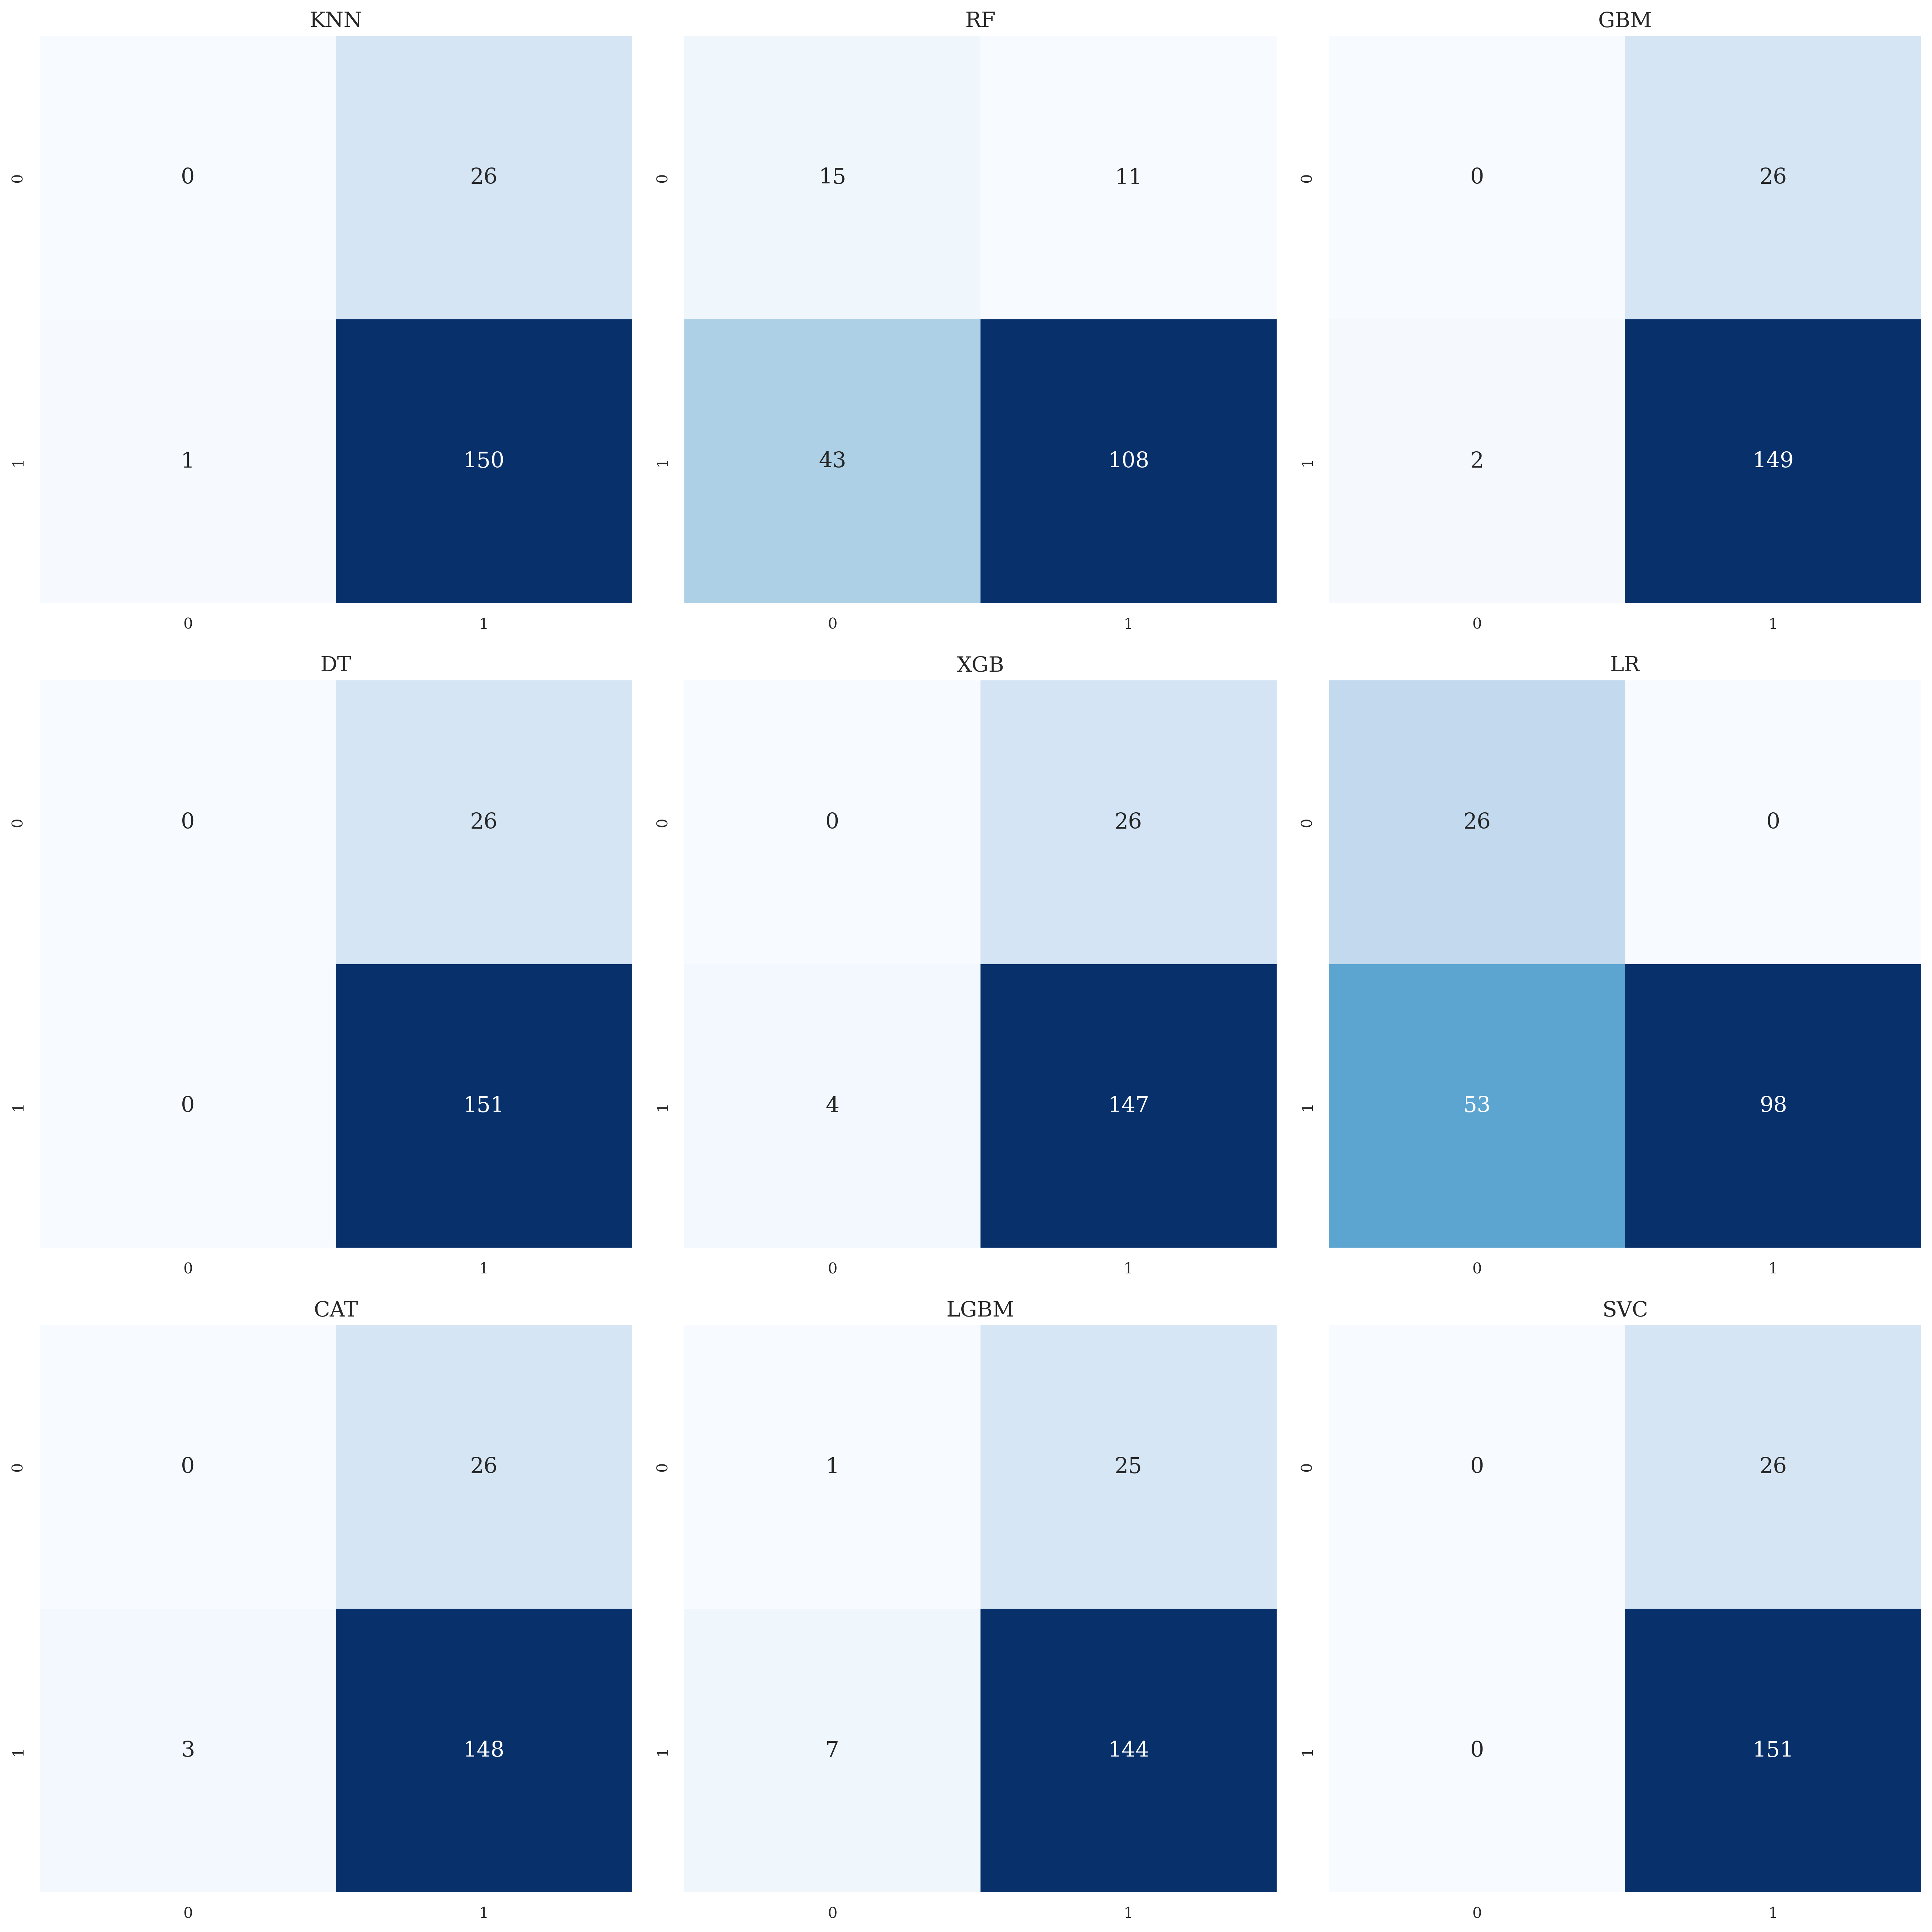

In [39]:


num_models = len(models)

# Increase DPI and figure size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), dpi=300)
axes = axes.flatten()
axs = 0

for i, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap= "Blues", cbar=False, ax=axes[axs])
    axes[axs].set_title(f'{i}')
    axs += 1

plt.tight_layout()
plt.savefig('visuals/confussion_martix.png')

In [40]:

import lime
import lime.lime_tabular
# Suppose 'models' is a dict of {model_name: model_instance}
# e.g., models = {"KNN": knn_model, "RandomForest": rf_model, "XGBoost": xgb_model, ...}

# Number of models
num_models = len(models)

# Create a color array, using the 'Set3' colormap for distinct colors
colors = plt.cm.Set3(np.linspace(0, 1, num_models))

# Initialize a 3x3 plot with high DPI
fig, axs = plt.subplots(3, 3, figsize=(30, 15), dpi=500)

model_index = 0

for i in range(3):
    for j in range(3):
        if model_index < num_models:
            name = list(models.keys())[model_index]
            model = models[name]
            print(f"Feature importance for {name}")

            # Fit the model
            model.fit(X_train, y_train)

            # LIME explainer
            explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=X_train.values,
                feature_names=X_train.columns,
                class_names=[str(cls) for cls in np.unique(y_train)],
                mode='classification'
            )

            # Choose a random instance for explanation
            instance = X_train.iloc[0].values.reshape(1, -1)
            exp = explainer.explain_instance(
                instance[0],
                model.predict_proba,
                num_features=X_train.shape[1]
            )

            # Extract and sort feature importance
            feature_importance = dict(exp.as_list())
            sorted_feature_importance = sorted(
                feature_importance.items(),
                key=lambda item: item[1],
                reverse=True
            )

            # Separate names and scores for plotting
            feature_names, feature_scores = zip(*sorted_feature_importance)

            # Assign a distinct color for this model
            bar_color = colors[model_index]

            # Plot the feature importance
            axs[i, j].barh(feature_names, feature_scores, color=bar_color)
            axs[i, j].set_title(f"{name} Feature Importance")

            model_index += 1
        else:
            # Remove unused axes (in case there are fewer than 9 models)
            fig.delaxes(axs[i, j])

# Legend ekleme
fig.legend(labels=models.values(), loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Adjust layout and save the combined plot
plt.tight_layout()
plt.savefig("visuals/3x3_feature_importance.png")
plt.show()


Feature importance for KNN
Feature importance for RF
Feature importance for GBM
Feature importance for DT
Feature importance for XGB
Feature importance for LR
Feature importance for CAT
Feature importance for LGBM
Feature importance for SVC


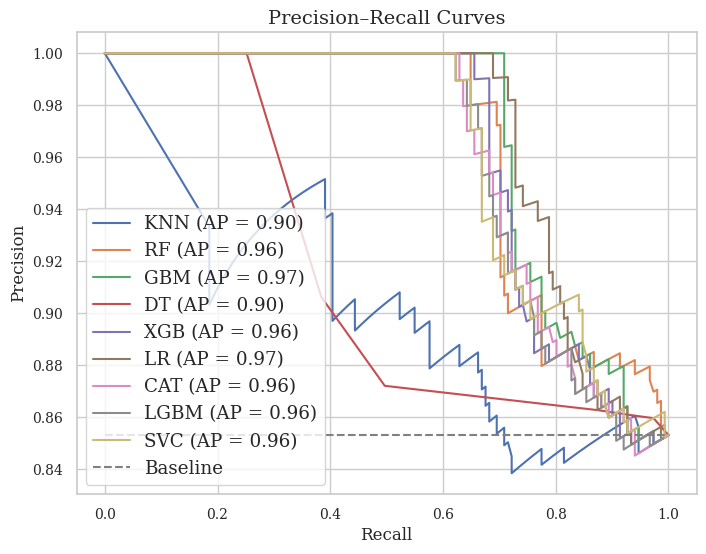

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Example models dictionary:
# models = {
#     "KNN": knn_model,
#     "RandomForest": rf_model,
#     "XGBoost": xgb_model,
#     ...
# }

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Fit the model (if not already trained)
    model.fit(X_train, y_train)

    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    
    # Compute average precision (area under the PR curve)
    avg_precision = average_precision_score(y_test, y_scores)

    # Plot the PR curve
    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")

# Optionally, plot a baseline
positive_class_ratio = (y_test == 1).mean()
plt.plot([0, 1], [positive_class_ratio, positive_class_ratio], linestyle='--', color='gray', label='Baseline')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [42]:
from joblib import dump
import os


# Create a folder to store the serialized models, if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

for model_name, model_instance in models.items():
    filename = f"saved_models/{model_name}.joblib"
    dump(model_instance, filename)
    print(f"Saved {model_name} model to {filename}")

Saved KNN model to saved_models/KNN.joblib
Saved RF model to saved_models/RF.joblib
Saved GBM model to saved_models/GBM.joblib
Saved DT model to saved_models/DT.joblib
Saved XGB model to saved_models/XGB.joblib
Saved LR model to saved_models/LR.joblib
Saved CAT model to saved_models/CAT.joblib
Saved LGBM model to saved_models/LGBM.joblib
Saved SVC model to saved_models/SVC.joblib
